## Setup

To run this notebook just install the packages (pandas, numpy, matplotlib, seaborn, scikit-learn) and run cells in order.

Should take about 1-2 min.

---

# Student Performance Analysis - ML Project

## Introduction
For this project im analyzing student performance data to figure out what factors actually affect exam scores. I'll build a machine learning model to predict scores and generate some recommendations.

## What I'm doing:
1. **Exploring the data** - look at the dataset and find key factors
2. **Building the model** - try different ML models and pick best one
3. **Testing with fake student** - create student profile and test predictions
4. **Making recommendations** - generate suggestions and test with the model

**Dataset**: StudentPerformanceFactors.csv (6607 records)
**Goal**: predictive model + actionable insights

---

## Chapter 1: Setup and Loading Data

First I need to import the libraries for data analysis and ML. Had to look up some of these imports.

In [27]:
# importing libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')  # dont want warnings cluttering output

import matplotlib.pyplot as plt
import seaborn as sns

# machine learning stuff
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# make plots look better
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries loaded successfully")

Libraries loaded successfully


## Chapter 2: Initial Data Exploration

Now ill load the dataset and do some basic exploration to understand what were working with.

In [2]:
# load dataset
df = pd.read_csv('StudentPerformanceFactors.csv')

print("Dataset loaded\n")
print(f"Size: {df.shape[0]:,} rows x {df.shape[1]} columns")
print("\nFirst few rows:")
print("="*70)
df.head()

Dataset loaded

Size: 6,607 rows x 20 columns

First few rows:


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [3]:
# check data structure
print("Dataset info:")
print("="*70)
df.info()

print("\nData types:")
print("="*70)
print(df.dtypes)

Dataset info:
<class 'pandas.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   Hours_Studied               6607 non-null   int64
 1   Attendance                  6607 non-null   int64
 2   Parental_Involvement        6607 non-null   str  
 3   Access_to_Resources         6607 non-null   str  
 4   Extracurricular_Activities  6607 non-null   str  
 5   Sleep_Hours                 6607 non-null   int64
 6   Previous_Scores             6607 non-null   int64
 7   Motivation_Level            6607 non-null   str  
 8   Internet_Access             6607 non-null   str  
 9   Tutoring_Sessions           6607 non-null   int64
 10  Family_Income               6607 non-null   str  
 11  Teacher_Quality             6529 non-null   str  
 12  School_Type                 6607 non-null   str  
 13  Peer_Influence              6607 non-null   str  
 14  Physi

In [4]:
# checking for missing values
print("="*70)
print("Missing values check:")
print("="*70)
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_percent
})
print(missing_df[missing_df['Missing Count'] > 0])

if missing.sum() == 0:
    print("\nNo missing values found.")
else:
    print(f"\nTotal missing: {missing.sum()} - will handle later")

Missing values check:
                          Missing Count  Percentage
Teacher_Quality                      78    1.180566
Parental_Education_Level             90    1.362192
Distance_from_Home                   67    1.014076

Total missing: 235 - will handle later


## Chapter 3: Exploratory Data Analysis (EDA)

Need to analyze the data and find out which factors actually matter for student performance.

### 3.1 Basic Statistics

In [5]:
# summary stats for numerical features
print("="*70)
print("Statistical Summary")
print("="*70)
df.describe().round(2)

Statistical Summary


,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
count,6607.00,6607.00,6607.00,6607.00,6607.00,6607.00,6607.00
mean,19.98,79.98,7.03,75.07,1.49,2.97,67.24
std,5.99,11.55,1.47,14.40,1.23,1.03,3.89
min,1.00,60.00,4.00,50.00,0.00,0.00,55.00
25%,16.00,70.00,6.00,63.00,1.00,2.00,65.00
50%,20.00,80.00,7.00,75.00,1.00,3.00,67.00
75%,24.00,90.00,8.00,88.00,2.00,4.00,69.00
max,44.00,100.00,10.00,100.00,8.00,6.00,101.00


In [6]:
# look at categorical features
print("="*70)
print("Categorical Features:")
print("="*70)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())
    print("-" * 50)

Categorical Features:

Parental_Involvement:
Parental_Involvement
Medium    3362
High      1908
Low       1337
Name: count, dtype: int64
--------------------------------------------------

Access_to_Resources:
Access_to_Resources
Medium    3319
High      1975
Low       1313
Name: count, dtype: int64
--------------------------------------------------

Extracurricular_Activities:
Extracurricular_Activities
Yes    3938
No     2669
Name: count, dtype: int64
--------------------------------------------------

Motivation_Level:
Motivation_Level
Medium    3351
Low       1937
High      1319
Name: count, dtype: int64
--------------------------------------------------

Internet_Access:
Internet_Access
Yes    6108
No      499
Name: count, dtype: int64
--------------------------------------------------

Family_Income:
Family_Income
Low       2672
Medium    2666
High      1269
Name: count, dtype: int64
--------------------------------------------------

Teacher_Quality:
Teacher_Quality
Medium    39

### 3.2 Exam Score Distribution

I want to see how scores are distributed - are they normal? any outliers?

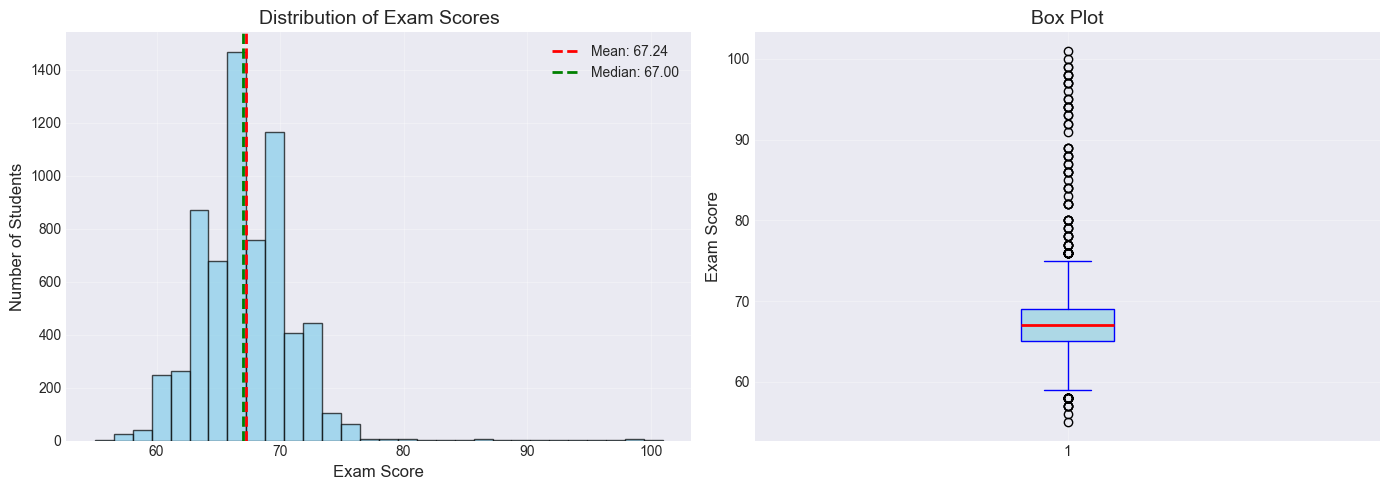


Exam Score Stats:
   Mean: 67.24
   Median: 67.00
   Std Dev: 3.89
   Min: 55
   Max: 101


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# histogram
axes[0].hist(df['Exam_Score'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Exam Score', fontsize=12)
axes[0].set_ylabel('Number of Students', fontsize=12)
axes[0].set_title('Distribution of Exam Scores', fontsize=14)
axes[0].axvline(df['Exam_Score'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {df["Exam_Score"].mean():.2f}')
axes[0].axvline(df['Exam_Score'].median(), color='green', linestyle='--', linewidth=2,
                label=f'Median: {df["Exam_Score"].median():.2f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# boxplot
axes[1].boxplot(df['Exam_Score'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='blue'),
                whiskerprops=dict(color='blue'),
                capprops=dict(color='blue'),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Exam Score', fontsize=12)
axes[1].set_title('Box Plot', fontsize=14)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nExam Score Stats:")
print(f"   Mean: {df['Exam_Score'].mean():.2f}")
print(f"   Median: {df['Exam_Score'].median():.2f}")
print(f"   Std Dev: {df['Exam_Score'].std():.2f}")
print(f"   Min: {df['Exam_Score'].min()}")
print(f"   Max: {df['Exam_Score'].max()}")

### 3.3 Correlation Analysis

Finding which factors correlate most with exam scores. Higher correlation = stronger relationship.

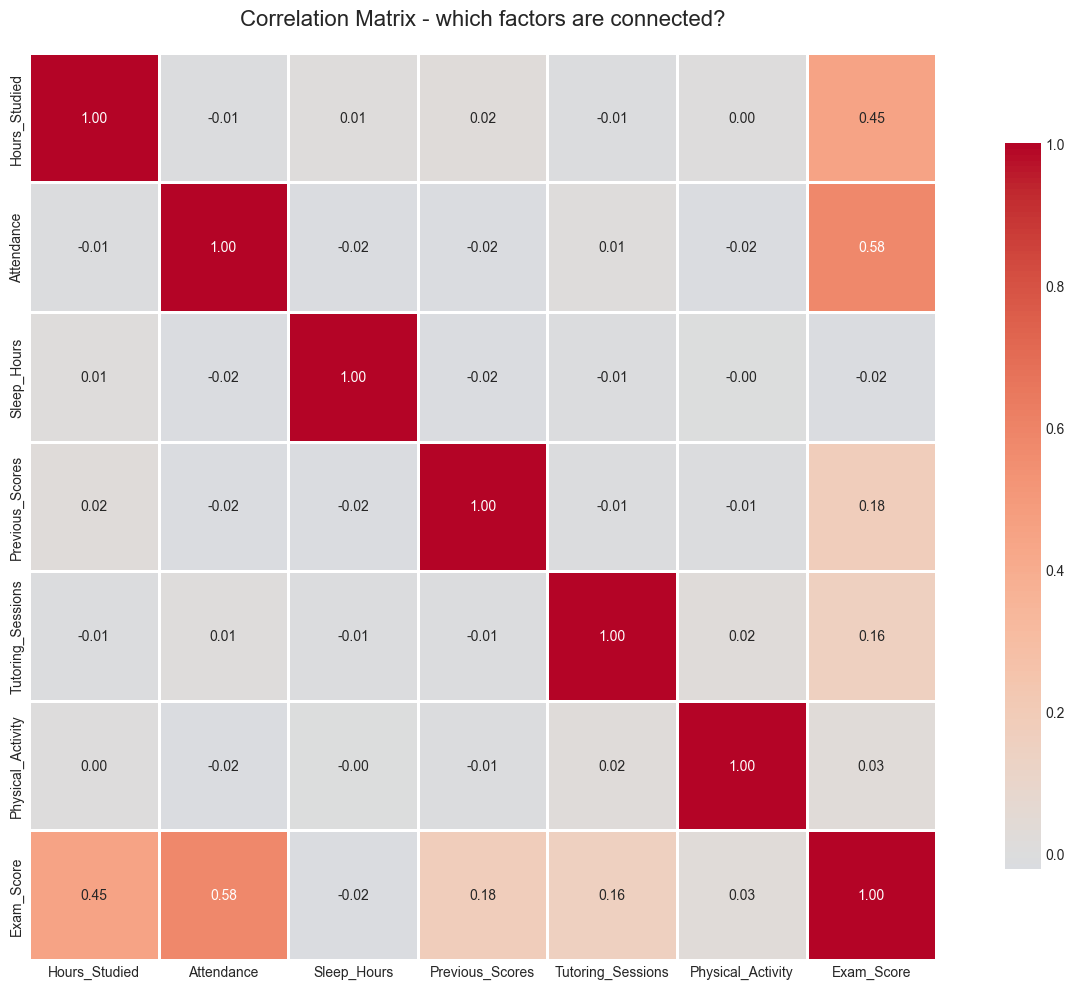

Correlation with Exam Score (sorted):
Exam_Score           1.000000
Attendance           0.581072
Hours_Studied        0.445455
Previous_Scores      0.175079
Tutoring_Sessions    0.156525
Physical_Activity    0.027824
Sleep_Hours         -0.017022
Name: Exam_Score, dtype: float64

Top 10 Most Important Factors:
#1. Attendance: 0.5811
#2. Hours_Studied: 0.4455
#3. Previous_Scores: 0.1751
#4. Tutoring_Sessions: 0.1565
#5. Physical_Activity: 0.0278
#6. Sleep_Hours: -0.0170

Note: Correlations closer to 1 or -1 = stronger relationship


In [8]:
# calculate correlations between numerical features
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

correlation_matrix = df[numerical_features].corr()
# took a while to figure out the right syntax for this

# heatmap to visualize
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - which factors are connected?',
          fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# focus on exam score correlations
print("="*70)
print("Correlation with Exam Score (sorted):")
print("="*70)
exam_corr = correlation_matrix['Exam_Score'].sort_values(ascending=False)
print(exam_corr)

# top factors
print("\n" + "="*70)
print("Top 10 Most Important Factors:")
print("="*70)
top_factors = exam_corr[exam_corr.index != 'Exam_Score'].abs().sort_values(ascending=False)
for i, (feature, corr_value) in enumerate(top_factors.head(10).items(), 1):
    print(f"#{i}. {feature}: {exam_corr[feature]:.4f}")

print("\nNote: Correlations closer to 1 or -1 = stronger relationship")

### 3.4 Visualizing Relationships

Plotting the top factors vs exam scores.

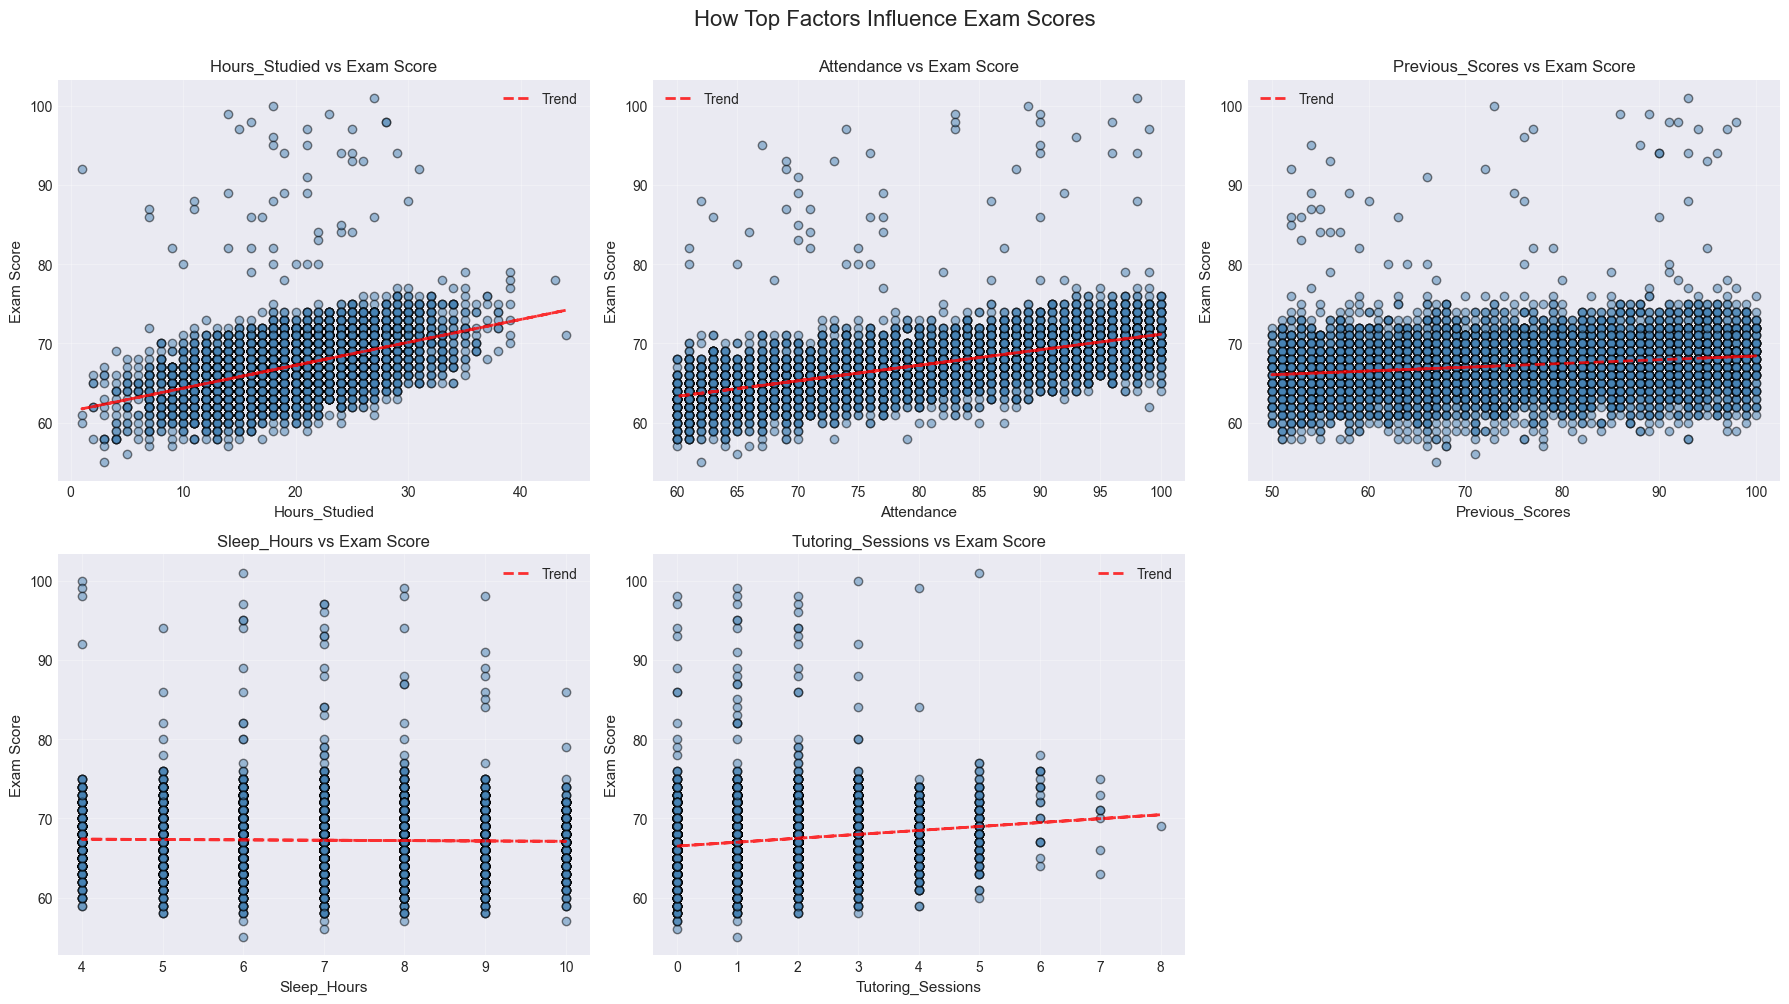


Trends are pretty clear from the plots.


In [9]:
# scatter plots for top features
top_features = ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Sleep_Hours', 'Tutoring_Sessions']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, feature in enumerate(top_features):
    axes[i].scatter(df[feature], df['Exam_Score'], alpha=0.5, color='steelblue', edgecolor='black')
    axes[i].set_xlabel(feature, fontsize=11)
    axes[i].set_ylabel('Exam Score', fontsize=11)
    axes[i].set_title(f'{feature} vs Exam Score', fontsize=12)
    axes[i].grid(alpha=0.3)

    # add trend line
    z = np.polyfit(df[feature], df['Exam_Score'], 1)
    p = np.poly1d(z)
    axes[i].plot(df[feature], p(df[feature]), "r--", linewidth=2, alpha=0.8, label='Trend')
    axes[i].legend()

axes[5].axis('off')

plt.suptitle('How Top Factors Influence Exam Scores', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

print("\nTrends are pretty clear from the plots.")

### 3.5 Categorical Factors Analysis

Let's also check how non-numerical factors (like motivation, parental involvement) affect average scores.

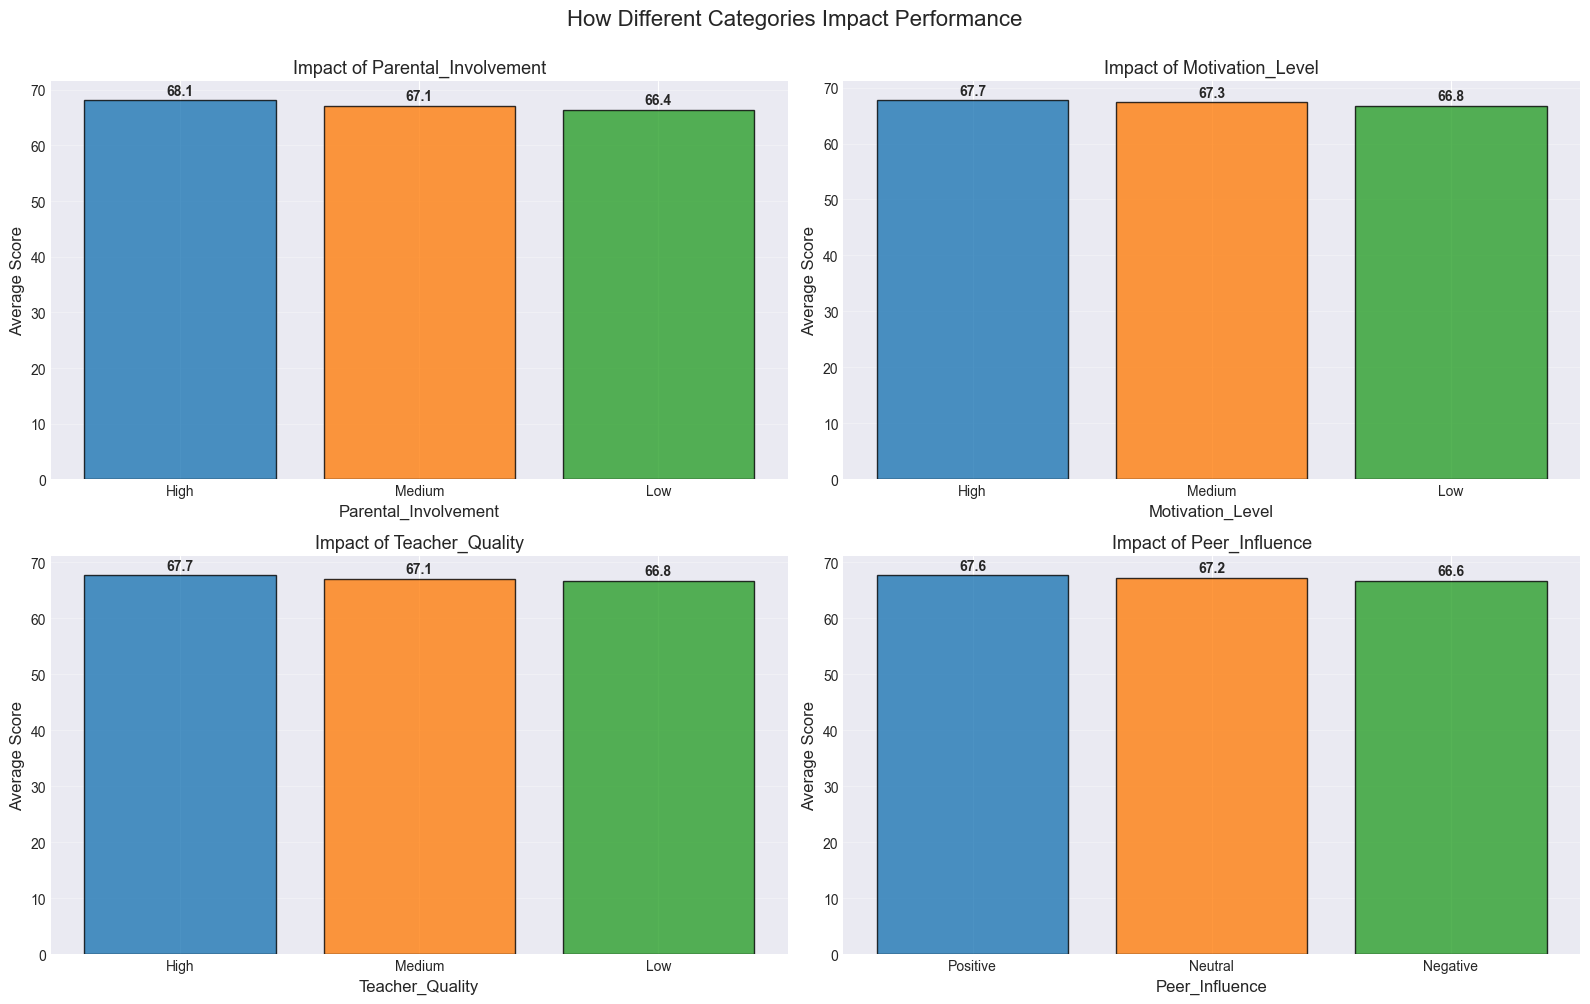

Detailed breakdown - average scores by category:

Parental_Involvement:
                      Average Score  Number of Students
Parental_Involvement                                   
High                      68.092767                1908
Medium                    67.098156                3362
Low                       66.358265                1337

Motivation_Level:
                  Average Score  Number of Students
Motivation_Level                                   
High                  67.704321                1319
Medium                67.330648                3351
Low                   66.752194                1937

Teacher_Quality:
                 Average Score  Number of Students
Teacher_Quality                                   
High                 67.676939                1947
Medium               67.109299                3925
Low                  66.753425                 657

Peer_Influence:
                Average Score  Number of Students
Peer_Influence               

In [10]:
# how do categories affect average scores?
categorical_features = ['Parental_Involvement', 'Motivation_Level', 'Teacher_Quality', 'Peer_Influence']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

for i, feature in enumerate(categorical_features):
    category_means = df.groupby(feature)['Exam_Score'].mean().sort_values(ascending=False)

    axes[i].bar(category_means.index, category_means.values,
                color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(category_means)],
                edgecolor='black', alpha=0.8)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Average Score', fontsize=12)
    axes[i].set_title(f'Impact of {feature}', fontsize=13)
    axes[i].grid(axis='y', alpha=0.3)

    # show values on bars
    for j, (cat, val) in enumerate(category_means.items()):
        axes[i].text(j, val + 0.5, f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('How Different Categories Impact Performance', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

# detailed breakdown
print("="*70)
print("Detailed breakdown - average scores by category:")
print("="*70)
for feature in categorical_features:
    print(f"\n{feature}:")
    stats = df.groupby(feature)['Exam_Score'].agg(['mean', 'count']).sort_values('mean', ascending=False)
    stats.columns = ['Average Score', 'Number of Students']
    print(stats)

## Chapter 4: Building the ML Model

Now for the actual model building - I'll try a few different models and see which works best.

### 4.1 Data Preprocessing

In [11]:
# need to convert everything to numbers so model can work with it
import pandas as pd
from pandas.api.types import is_numeric_dtype

df_processed = df.copy()

# handle missing values if any
for col in df_processed.columns:
    if df_processed[col].isnull().sum() > 0:
        if is_numeric_dtype(df_processed[col]):
            df_processed[col].fillna(df_processed[col].median(), inplace=True)
        else:
            df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

print("Missing values handled\n")

# encode categories to numbers
label_encoders = {}
categorical_columns = df_processed.select_dtypes(include=['object']).columns.tolist()

print("="*70)
print("Converting categories to numbers:")
print("="*70)

for col in categorical_columns:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le
    print(f"{col}: {list(le.classes_)}")

print("\nAll data is now numerical.")

Missing values handled

Converting categories to numbers:
Parental_Involvement: ['High', 'Low', 'Medium']
Access_to_Resources: ['High', 'Low', 'Medium']
Extracurricular_Activities: ['No', 'Yes']
Motivation_Level: ['High', 'Low', 'Medium']
Internet_Access: ['No', 'Yes']
Family_Income: ['High', 'Low', 'Medium']
Teacher_Quality: ['High', 'Low', 'Medium', nan]
School_Type: ['Private', 'Public']
Peer_Influence: ['Negative', 'Neutral', 'Positive']
Learning_Disabilities: ['No', 'Yes']
Parental_Education_Level: ['College', 'High School', 'Postgraduate', nan]
Distance_from_Home: ['Far', 'Moderate', 'Near', nan]
Gender: ['Female', 'Male']

All data is now numerical.


### 4.2 Train/Test Split

Split data 80/20 - train on 80% and test on the remaining 20% to see how well it performs.

In [12]:
# separate features from target
X = df_processed.drop('Exam_Score', axis=1)
y = df_processed['Exam_Score']

print("="*70)
print("Preparing features and target:")
print("="*70)
print(f"Features (X): {X.shape[1]} factors")
print(f"Target (y): scores for {len(y):,} students")

# split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set: {len(X_train):,} students")
print(f"Test set: {len(X_test):,} students")

# scale features (important!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData split and scaled successfully.")

Preparing features and target:
Features (X): 19 factors
Target (y): scores for 6,607 students

Training set: 5,285 students
Test set: 1,322 students

Data split and scaled successfully.


### 4.3 Training Models

Trying 3 different model types: Linear Regression, Random Forest, and Gradient Boosting. Will compare and pick best one.

In [13]:
# create 3 different models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# train and evaluate
results = {}
print("="*70)
print("Training models:")
print("="*70)

for name, model in models.items():
    print(f"\nTraining {name}...")

    model.fit(X_train_scaled, y_train)

    # make predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    # calculate metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae = mean_absolute_error(y_test, y_pred_test)

    results[name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'rmse': rmse,
        'mae': mae,
        'predictions': y_pred_test
    }

    print(f"{name} complete")
    print(f"   Training R2: {train_r2:.4f}")
    print(f"   Test R2: {test_r2:.4f}")
    print(f"   MAE: {mae:.4f} points")
    print(f"   RMSE: {rmse:.4f}")

print("\nHigher R2 = better model")

Training models:

Training Linear Regression...
Linear Regression complete
   Training R2: 0.6424
   Test R2: 0.6886
   MAE: 1.0157 points
   RMSE: 2.0979

Training Random Forest...
Random Forest complete
   Training R2: 0.9471
   Test R2: 0.6572
   MAE: 1.1230 points
   RMSE: 2.2013

Training Gradient Boosting...
Gradient Boosting complete
   Training R2: 0.7377
   Test R2: 0.7311
   MAE: 0.8238 points
   RMSE: 1.9495

Higher R2 = better model


In [14]:
# compare models
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train R2': [results[m]['train_r2'] for m in results.keys()],
    'Test R2': [results[m]['test_r2'] for m in results.keys()],
    'RMSE': [results[m]['rmse'] for m in results.keys()],
    'MAE': [results[m]['mae'] for m in results.keys()]
})

print("\n" + "="*70)
print("Model Performance Comparison:")
print("="*70)
print(comparison_df.to_string(index=False))

# pick best model (highest Test R2)
best_model_name = comparison_df.loc[comparison_df['Test R2'].idxmax(), 'Model']
best_model = results[best_model_name]['model']

print("\n" + "="*70)
print(f"Best model: {best_model_name}")
print("="*70)
print(f"Test R2: {results[best_model_name]['test_r2']:.4f}")
print(f"MAE: {results[best_model_name]['mae']:.4f} points")
print(f"RMSE: {results[best_model_name]['rmse']:.4f}")
print("\nUsing this model for predictions.")


Model Performance Comparison:
            Model  Train R2  Test R2     RMSE      MAE
Linear Regression  0.642390 0.688619 2.097948 1.015673
    Random Forest  0.947055 0.657177 2.201324 1.122950
Gradient Boosting  0.737746 0.731129 1.949492 0.823786

Best model: Gradient Boosting
Test R2: 0.7311
MAE: 0.8238 points
RMSE: 1.9495

Using this model for predictions.


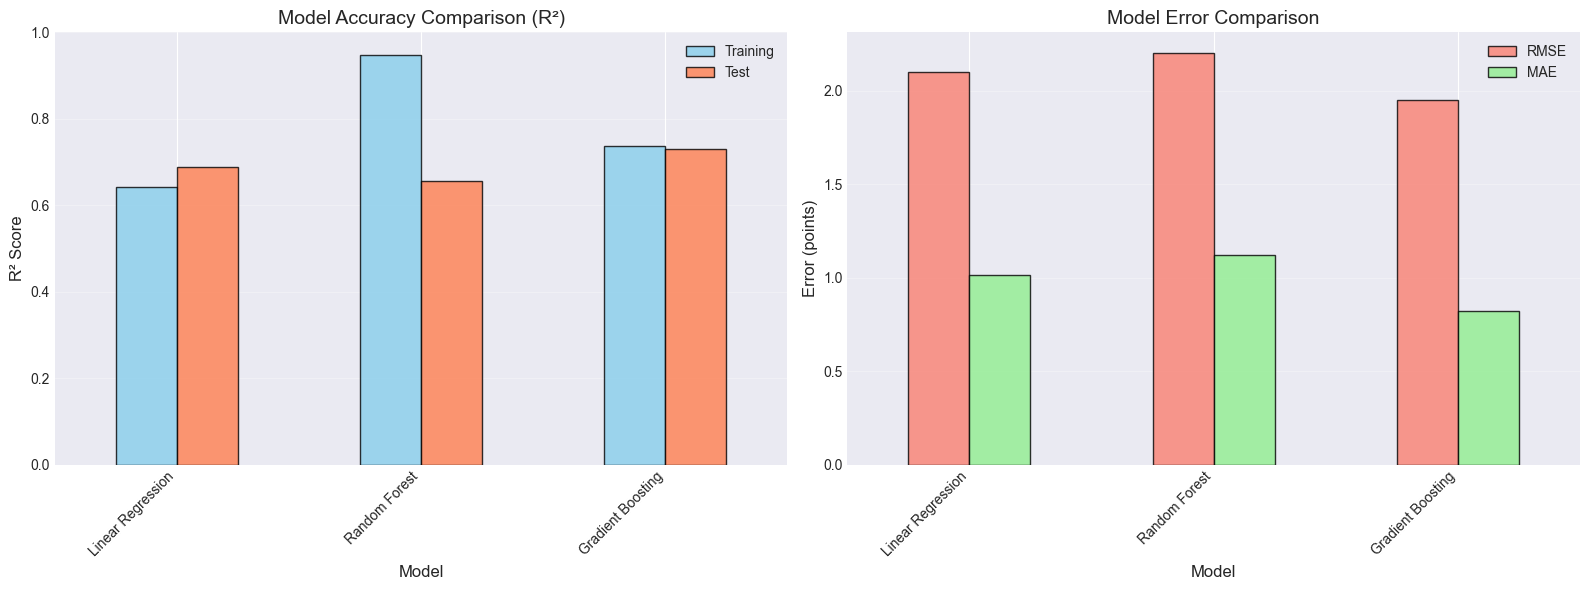

In [15]:
# visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# R² scores
r2_scores = comparison_df[['Model', 'Train R2', 'Test R2']].set_index('Model')
r2_scores.plot(kind='bar', ax=axes[0], color=['skyblue', 'coral'], edgecolor='black', alpha=0.8)
axes[0].set_title('Model Accuracy Comparison (R²)', fontsize=14)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].legend(['Training', 'Test'])
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_ylim([0, 1])

# errors
error_metrics = comparison_df[['Model', 'RMSE', 'MAE']].set_index('Model')
error_metrics.plot(kind='bar', ax=axes[1], color=['salmon', 'lightgreen'], edgecolor='black', alpha=0.8)
axes[1].set_title('Model Error Comparison', fontsize=14)
axes[1].set_ylabel('Error (points)', fontsize=12)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].legend(['RMSE', 'MAE'])
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


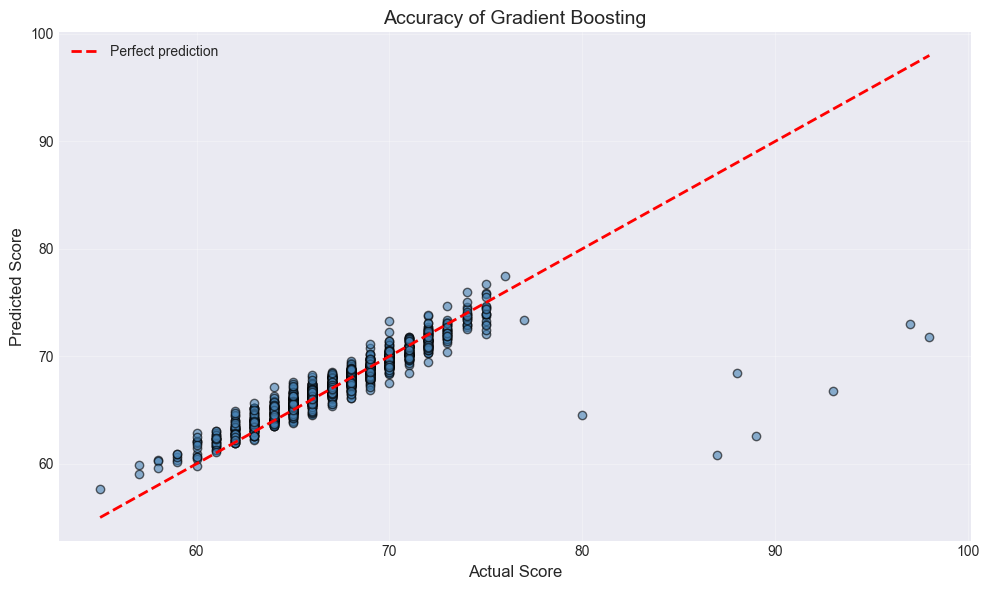


Points closer to red line = more accurate predictions


In [16]:
# how accurate are predictions?
plt.figure(figsize=(10, 6))
plt.scatter(y_test, results[best_model_name]['predictions'], alpha=0.6, color='steelblue', edgecolor='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
plt.xlabel('Actual Score', fontsize=12)
plt.ylabel('Predicted Score', fontsize=12)
plt.title(f'Accuracy of {best_model_name}', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nPoints closer to red line = more accurate predictions")

### 4.4 Feature Importance

Checking which features the model thinks are most important.

What Gradient Boosting learned:

Most important features:

                   Feature  Importance
                Attendance    0.466821
             Hours_Studied    0.284031
           Previous_Scores    0.050061
       Access_to_Resources    0.039368
      Parental_Involvement    0.038202
         Tutoring_Sessions    0.036430
            Peer_Influence    0.013550
             Family_Income    0.012589
  Parental_Education_Level    0.009252
          Motivation_Level    0.008658
        Distance_from_Home    0.008508
           Teacher_Quality    0.007516
Extracurricular_Activities    0.007246
     Learning_Disabilities    0.006058
         Physical_Activity    0.005579
           Internet_Access    0.005090
               Sleep_Hours    0.001039
               School_Type    0.000000
                    Gender    0.000000


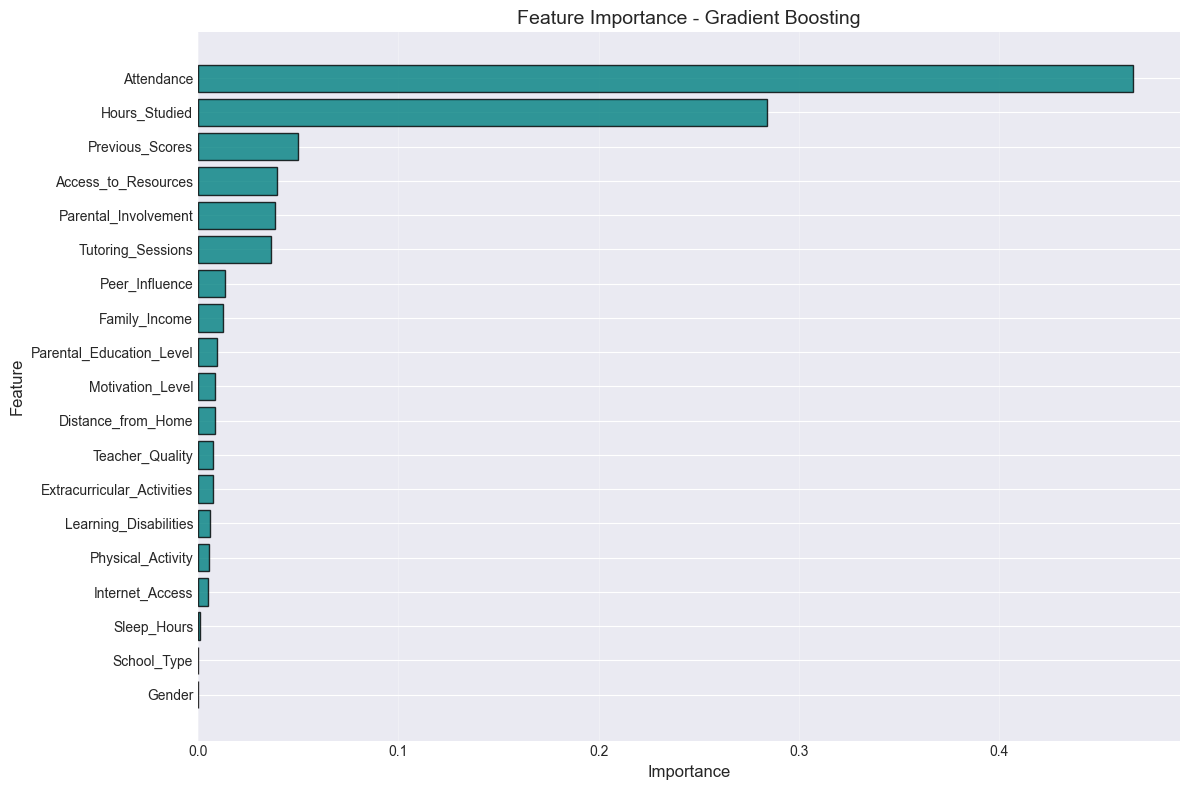

In [17]:
# which features are most important?
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("="*70)
    print(f"What {best_model_name} learned:")
    print("="*70)
    print("\nMost important features:\n")
    print(feature_importance.to_string(index=False))

    # plot it
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'],
             color='teal', edgecolor='black', alpha=0.8)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title(f'Feature Importance - {best_model_name}', fontsize=14)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print(f"\n{best_model_name} doesn't provide feature importances directly.")

## Chapter 5: Testing with Fictitious Student

Creating a fake student profile to test model predictions.

### 5.1 Student Profile - "Alex"

In [18]:
# creating a student profile with some problems

fictitious_student_raw = {
    'Hours_Studied': 12,                      # below average
    'Attendance': 65,                         # poor attendance
    'Parental_Involvement': 'Low',
    'Access_to_Resources': 'Medium',
    'Extracurricular_Activities': 'No',
    'Sleep_Hours': 5,                         # not enough sleep
    'Previous_Scores': 55,
    'Motivation_Level': 'Low',
    'Internet_Access': 'Yes',
    'Tutoring_Sessions': 0,                   # no tutoring
    'Family_Income': 'Low',
    'Teacher_Quality': 'Medium',
    'School_Type': 'Public',
    'Peer_Influence': 'Negative',             # bad peer influence
    'Physical_Activity': 2,
    'Learning_Disabilities': 'No',
    'Parental_Education_Level': 'High School',
    'Distance_from_Home': 'Far',
    'Gender': 'Male'
}

print("="*70)
print("FICTITIOUS STUDENT PROFILE - ALEX")
print("="*70)
print("\nCharacteristics:")
print("-" * 70)
for key, value in fictitious_student_raw.items():
    print(f"  {key:30s}: {value}")
print("="*70)

FICTITIOUS STUDENT PROFILE - ALEX

Characteristics:
----------------------------------------------------------------------
  Hours_Studied                 : 12
  Attendance                    : 65
  Parental_Involvement          : Low
  Access_to_Resources           : Medium
  Extracurricular_Activities    : No
  Sleep_Hours                   : 5
  Previous_Scores               : 55
  Motivation_Level              : Low
  Internet_Access               : Yes
  Tutoring_Sessions             : 0
  Family_Income                 : Low
  Teacher_Quality               : Medium
  School_Type                   : Public
  Peer_Influence                : Negative
  Physical_Activity             : 2
  Learning_Disabilities         : No
  Parental_Education_Level      : High School
  Distance_from_Home            : Far
  Gender                        : Male


### 5.2 Model Prediction

In [19]:
# function to process data and make predictions
# this part was tricky to get right
def predict_student_score(student_data, model, scaler, label_encoders, feature_columns):
    student_processed = student_data.copy()

    # encode categories
    for col, encoder in label_encoders.items():
        if col in student_processed:
            student_processed[col] = encoder.transform([str(student_processed[col])])[0]

    # correct feature order
    student_df = pd.DataFrame([student_processed])[feature_columns]

    # scale
    student_scaled = scaler.transform(student_df)

    # predict
    prediction = model.predict(student_scaled)[0]

    return prediction

# generate prediction for Alex
predicted_score = predict_student_score(
    fictitious_student_raw,
    best_model,
    scaler,
    label_encoders,
    X.columns
)

print("\n" + "="*70)
print("PREDICTION RESULT:")
print("="*70)
print(f"Predicted exam score for Alex: {predicted_score:.2f} points")
print("="*70)


PREDICTION RESULT:
Predicted exam score for Alex: 57.63 points


## Chapter 6: Recommendations for Improvement

Based on model predictions and data analysis, generate concrete recommendations for Alex to improve score.

### 6.1 Identifying Issues

In [20]:
# analyze Alex's situation
print("="*70)
print("SITUATION ANALYSIS:")
print("="*70)
print(f"\nCurrent predicted score: {predicted_score:.2f} / 100")
print("\nIdentified problems:")
print("-" * 70)

issues = []
if fictitious_student_raw['Hours_Studied'] < df['Hours_Studied'].median():
    issues.append(f"- Low study hours: {fictitious_student_raw['Hours_Studied']} hrs/week (median: {df['Hours_Studied'].median():.0f})")

if fictitious_student_raw['Attendance'] < df['Attendance'].median():
    issues.append(f"- Poor attendance: {fictitious_student_raw['Attendance']}% (median: {df['Attendance'].median():.0f}%)")

if fictitious_student_raw['Sleep_Hours'] < 7:
    issues.append(f"- Insufficient sleep: {fictitious_student_raw['Sleep_Hours']} hours (recommended: 7-9)")

if fictitious_student_raw['Motivation_Level'] == 'Low':
    issues.append(f"- Low motivation")

if fictitious_student_raw['Tutoring_Sessions'] == 0:
    issues.append(f"- No tutoring support")

if fictitious_student_raw['Parental_Involvement'] == 'Low':
    issues.append(f"- Low parental involvement")

if fictitious_student_raw['Peer_Influence'] == 'Negative':
    issues.append(f"- Negative peer influence")

for issue in issues:
    print(f"   {issue}")

print("\n" + "="*70)

SITUATION ANALYSIS:

Current predicted score: 57.63 / 100

Identified problems:
----------------------------------------------------------------------
   - Low study hours: 12 hrs/week (median: 20)
   - Poor attendance: 65% (median: 80%)
   - Insufficient sleep: 5 hours (recommended: 7-9)
   - Low motivation
   - No tutoring support
   - Low parental involvement
   - Negative peer influence



### 6.2 Improvement Suggestions

5 main suggestions based on correlation analysis and feature importance.

In [21]:
# define improvement suggestions
suggestions = {
    'Suggestion 1: Increase study time': {
        'description': 'Increase weekly study hours from 12 to 20',
        'motivation': f'''Data shows study hours have strong positive correlation with scores.
Alex is studying {fictitious_student_raw['Hours_Studied']} hrs/week, below median of {df['Hours_Studied'].median():.0f}.
Getting to 20 hours would put Alex near 75th percentile - what successful students do.
This is doable - just means adding 1-2 hours focused study per day.''',
        'changes': {'Hours_Studied': 20}
    },

    'Suggestion 2: Improve attendance': {
        'description': 'Improve attendance from 65% to 90%',
        'motivation': f'''Attendance is one of top predictors. At 65%, Alex is missing 1 in 3 classes.
Median is {df['Attendance'].median():.0f}%. Getting to 90% means being there for almost everything.
Cant learn what you dont hear - every missed class means catching up later which is harder.''',
        'changes': {'Attendance': 90}
    },

    'Suggestion 3: Add tutoring': {
        'description': 'Start attending 3 tutoring sessions per week',
        'motivation': '''Data shows students with tutoring consistently score higher.
Alex currently has no tutoring. Just 3 weekly sessions provide:
- personalized help on problem areas
- chance to ask questions
- regular check-ins
Many schools offer free tutoring.''',
        'changes': {'Tutoring_Sessions': 3}
    },

    'Suggestion 4: Get more sleep': {
        'description': 'Increase sleep from 5 to 8 hours per night',
        'motivation': '''5 hours is serious sleep deprivation. Brain needs 7-9 hours to function properly.
Sleep is when your brain consolidates what you learned and recharges for focus.
With only 5 hours, trying to learn with exhausted brain.
Set bedtime, turn off screens 1 hour before.''',
        'changes': {'Sleep_Hours': 8}
    },

    'Suggestion 5: Boost motivation': {
        'description': 'Work with counselor to boost motivation from Low to High',
        'motivation': '''Low motivation creates vicious cycle - poor results lead to less motivation.
Counselor can help Alex:
- set meaningful goals
- find what interests them
- develop growth mindset
- connect academics to future
Small mindset shifts create big changes.''',
        'changes': {'Motivation_Level': 'High'}
    }
}

print("="*70)
print("5 KEY RECOMMENDATIONS FOR ALEX:")
print("="*70)
for i, (title, details) in enumerate(suggestions.items(), 1):
    print(f"\n{i}. {title}")
    print(f"    {details['description']}")
print("\n" + "="*70)
print("Now testing each suggestion to see potential impact.")
print("="*70)

5 KEY RECOMMENDATIONS FOR ALEX:

1. Suggestion 1: Increase study time
    Increase weekly study hours from 12 to 20

2. Suggestion 2: Improve attendance
    Improve attendance from 65% to 90%

3. Suggestion 3: Add tutoring
    Start attending 3 tutoring sessions per week

4. Suggestion 4: Get more sleep
    Increase sleep from 5 to 8 hours per night

5. Suggestion 5: Boost motivation
    Work with counselor to boost motivation from Low to High

Now testing each suggestion to see potential impact.


### 6.3 Testing Individual Suggestions

Test each suggestion separately to see how much it helps.

In [22]:
# test each suggestion individually
results_individual = []

print("="*70)
print("TESTING INDIVIDUAL SUGGESTIONS:")
print("="*70)
print(f"\nAlex current predicted score: {predicted_score:.2f} points")
print("\nSee how each change helps:\n")
print("-"*70)

for title, details in suggestions.items():
    # modify just one thing
    modified_student = fictitious_student_raw.copy()
    modified_student.update(details['changes'])

    # predict new score
    new_score = predict_student_score(
        modified_student,
        best_model,
        scaler,
        label_encoders,
        X.columns
    )

    improvement = new_score - predicted_score
    improvement_pct = (improvement / predicted_score) * 100

    results_individual.append({
        'Suggestion': title,
        'Current Score': predicted_score,
        'New Score': new_score,
        'Improvement': improvement,
        'Improvement %': improvement_pct
    })

    print(f"\n{title}")
    print(f"   Change: {details['description']}")
    print(f"   New predicted score: {new_score:.2f} points")
    print(f"   Score gain: +{improvement:.2f} points ({improvement_pct:+.2f}%)")
    print("-"*70)

# summary table
results_df = pd.DataFrame(results_individual)
print("\n" + "="*70)
print("IMPACT SUMMARY:")
print("="*70)
print(results_df[['Suggestion', 'New Score', 'Improvement']].to_string(index=False))
print("="*70)

TESTING INDIVIDUAL SUGGESTIONS:

Alex current predicted score: 57.63 points

See how each change helps:

----------------------------------------------------------------------

Suggestion 1: Increase study time
   Change: Increase weekly study hours from 12 to 20
   New predicted score: 60.25 points
   Score gain: +2.62 points (+4.55%)
----------------------------------------------------------------------

Suggestion 2: Improve attendance
   Change: Improve attendance from 65% to 90%
   New predicted score: 63.40 points
   Score gain: +5.78 points (+10.02%)
----------------------------------------------------------------------

Suggestion 3: Add tutoring
   Change: Start attending 3 tutoring sessions per week
   New predicted score: 58.62 points
   Score gain: +0.99 points (+1.72%)
----------------------------------------------------------------------

Suggestion 4: Get more sleep
   Change: Increase sleep from 5 to 8 hours per night
   New predicted score: 57.63 points
   Score gain: 

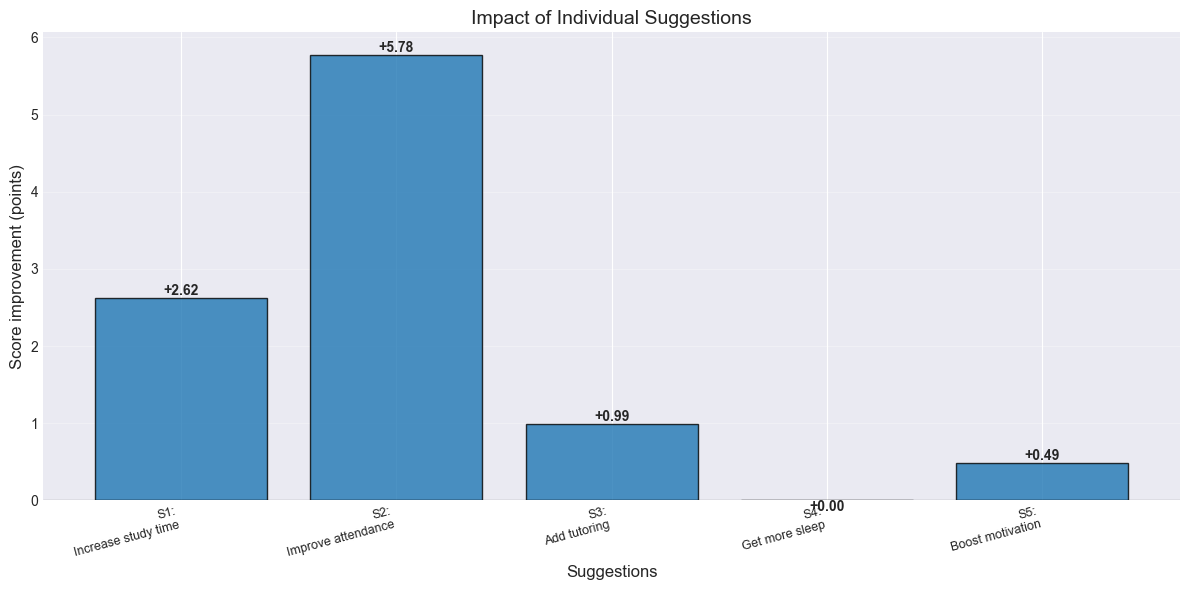

In [23]:
# visualize individual improvements
plt.figure(figsize=(12, 6))
suggestions_short = [s.replace('Suggestion ', 'S').replace(': ', ':\n') for s in results_df['Suggestion']]
colors = ['#1f77b4' if imp > 0 else '#d62728' for imp in results_df['Improvement']]

bars = plt.bar(range(len(results_df)), results_df['Improvement'],
               color=colors, edgecolor='black', alpha=0.8)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
plt.xlabel('Suggestions', fontsize=12)
plt.ylabel('Score improvement (points)', fontsize=12)
plt.title('Impact of Individual Suggestions', fontsize=14)
plt.xticks(range(len(results_df)), suggestions_short, rotation=15, ha='right', fontsize=9)
plt.grid(axis='y', alpha=0.3)

# add values on bars
for i, (bar, val) in enumerate(zip(bars, results_df['Improvement'])):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'+{val:.2f}',
            ha='center', va='bottom' if val > 0 else 'top',
            fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

### 6.4 Combining All Suggestions

What if Alex did ALL suggestions? Check the full potential.

In [24]:
# apply suggestions progressively
print("="*70)
print("PROGRESSIVE IMPROVEMENT:")
print("="*70)

combined_results = [{'Stage': 'Starting point', 'Score': predicted_score, 'Added': 'None'}]
improved_student = fictitious_student_raw.copy()

# sort by impact
sorted_suggestions = sorted(suggestions.items(),
                           key=lambda x: [r for r in results_individual
                                        if r['Suggestion'] == x[0]][0]['Improvement'],
                           reverse=True)

print(f"\nStarting score: {predicted_score:.2f} points\n")

for i, (title, details) in enumerate(sorted_suggestions, 1):
    improved_student.update(details['changes'])

    new_score = predict_student_score(
        improved_student,
        best_model,
        scaler,
        label_encoders,
        X.columns
    )

    short_name = title.split(': ')[1]
    combined_results.append({
        'Stage': f'After step {i}',
        'Score': new_score,
        'Added': short_name
    })

    improvement = new_score - predicted_score
    step_gain = new_score - combined_results[-2]['Score']

    print(f"Step {i}: {title}")
    print(f"   Cumulative score: {new_score:.2f} points")
    print(f"   Step gain: +{step_gain:.2f} points")
    print(f"   Total from start: +{improvement:.2f} points\n")

# final results
final_score = combined_results[-1]['Score']
total_improvement = final_score - predicted_score
total_improvement_pct = (total_improvement / predicted_score) * 100

print("="*70)
print("FINAL RESULTS:")
print("="*70)
print(f"\n   Starting:  {predicted_score:.2f} points")
print(f"   Final:     {final_score:.2f} points")
print(f"   \n   TOTAL IMPROVEMENT: +{total_improvement:.2f} points ({total_improvement_pct:+.2f}%)")
print("\n" + "="*70)
print(f"Thats a {total_improvement:.1f}-point increase")
print("="*70)

PROGRESSIVE IMPROVEMENT:

Starting score: 57.63 points

Step 1: Suggestion 2: Improve attendance
   Cumulative score: 63.40 points
   Step gain: +5.78 points
   Total from start: +5.78 points

Step 2: Suggestion 1: Increase study time
   Cumulative score: 65.60 points
   Step gain: +2.20 points
   Total from start: +7.97 points

Step 3: Suggestion 3: Add tutoring
   Cumulative score: 66.66 points
   Step gain: +1.05 points
   Total from start: +9.03 points

Step 4: Suggestion 5: Boost motivation
   Cumulative score: 66.81 points
   Step gain: +0.15 points
   Total from start: +9.18 points

Step 5: Suggestion 4: Get more sleep
   Cumulative score: 66.81 points
   Step gain: +0.00 points
   Total from start: +9.18 points

FINAL RESULTS:

   Starting:  57.63 points
   Final:     66.81 points
   
   TOTAL IMPROVEMENT: +9.18 points (+15.93%)

Thats a 9.2-point increase


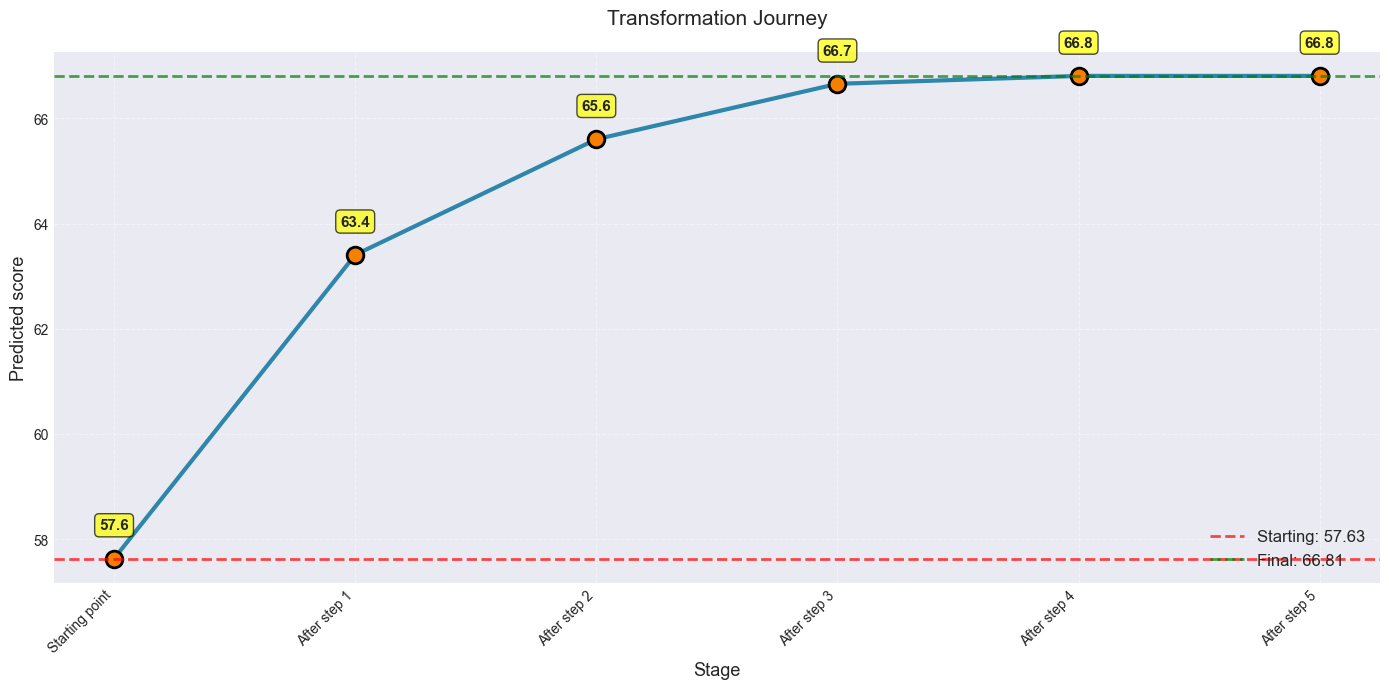


PROGRESSION TABLE:
         Stage     Score               Added
Starting point 57.629104                None
  After step 1 63.404964  Improve attendance
  After step 2 65.602306 Increase study time
  After step 3 66.656744        Add tutoring
  After step 4 66.807044    Boost motivation
  After step 5 66.807044      Get more sleep


In [25]:
# visualize transformation journey
combined_df = pd.DataFrame(combined_results)

plt.figure(figsize=(14, 7))
plt.plot(combined_df['Stage'], combined_df['Score'],
         marker='o', linewidth=3, markersize=12,
         color='#2E86AB', markerfacecolor='#F77F00', markeredgecolor='black', markeredgewidth=2)
plt.axhline(y=predicted_score, color='red', linestyle='--', linewidth=2,
            label=f'Starting: {predicted_score:.2f}', alpha=0.7)
plt.axhline(y=final_score, color='green', linestyle='--', linewidth=2,
            label=f'Final: {final_score:.2f}', alpha=0.7)

plt.xlabel('Stage', fontsize=13)
plt.ylabel('Predicted score', fontsize=13)
plt.title('Transformation Journey',
          fontsize=15, pad=20)
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.4, linestyle='--')
plt.legend(fontsize=12, loc='lower right')

# add labels
for i, row in combined_df.iterrows():
    plt.text(i, row['Score'] + 0.5, f"{row['Score']:.1f}",
            ha='center', va='bottom', fontweight='bold', fontsize=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

# progression table
print("\n" + "="*70)
print("PROGRESSION TABLE:")
print("="*70)
print(combined_df.to_string(index=False))
print("="*70)

In [26]:
print("="*70)
print("ACTION PLAN FOR ALEX")
print("="*70)
print(f"\nCurrent situation:")
print(f"   Predicted score: {predicted_score:.2f} points")
print(f"\nWith improvements:")
print(f"   Achievable score: {final_score:.2f} points")
print(f"   Total improvement: +{total_improvement:.2f} points ({total_improvement_pct:+.1f}%)")

print("\n" + "="*70)
print("RECOMMENDED ACTIONS (By impact):")
print("="*70)

for i, (title, details) in enumerate(sorted_suggestions, 1):
    individual_impact = [r for r in results_individual if r['Suggestion'] == title][0]

    print(f"\n{'='*70}")
    print(f"Priority {i}: {title}")
    print('='*70)
    print(f"\nAction:")
    print(f"   {details['description']}")

    print(f"\nWhy:")
    for line in details['motivation'].strip().split('\n'):
        if line.strip():
            print(f"   {line.strip()}")

    print(f"\nExpected impact:")
    print(f"   Score increase: +{individual_impact['Improvement']:.2f} points")
    print(f"   Gain: +{individual_impact['Improvement %']:.2f}%")

print("\n" + "="*70)
print("SUMMARY:")
print("="*70)
print(f"""
ML model analyzed {len(df):,} student records to generate these recommendations.

Key points:

   - Recommendations prioritized by predicted impact
   - Each tested individually
   - Combined effect: {total_improvement:.1f} points improvement
   - Data-driven approach based on actual patterns

Should implement gradually, starting with highest-impact changes.
""")
print("="*70)

ACTION PLAN FOR ALEX

Current situation:
   Predicted score: 57.63 points

With improvements:
   Achievable score: 66.81 points
   Total improvement: +9.18 points (+15.9%)

RECOMMENDED ACTIONS (By impact):

Priority 1: Suggestion 2: Improve attendance

Action:
   Improve attendance from 65% to 90%

Why:
   Attendance is one of top predictors. At 65%, Alex is missing 1 in 3 classes.
   Median is 80%. Getting to 90% means being there for almost everything.
   Cant learn what you dont hear - every missed class means catching up later which is harder.

Expected impact:
   Score increase: +5.78 points
   Gain: +10.02%

Priority 2: Suggestion 1: Increase study time

Action:
   Increase weekly study hours from 12 to 20

Why:
   Data shows study hours have strong positive correlation with scores.
   Alex is studying 12 hrs/week, below median of 20.
   Getting to 20 hours would put Alex near 75th percentile - what successful students do.
   This is doable - just means adding 1-2 hours focused s